# Analysis of (Haber et al., 2017)

We want to re-analyze the data from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489). 
The dataset contains cell compositions of the intestinal epithelium of mice under 4 conditions
(control, Salmonella infection, H. polygyrus infection (3 days), and H. polygyrus infection (10 days)).

In the original paper, differential abundance was tested via a Poisson regression model, 
not taking compositional effects into account.
We want to analyze whether the findings are consistent with scCODA.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.model import other_models as om

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [2]:
cell_counts = pd.read_csv("../../scCODA/data/haber_counts.csv")

cell_counts["Condition"] = cell_counts["Mouse"].str.replace(r"_[0-9]", "")
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse", "Condition"])

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft     Condition  
0  125       191    18       Control  
1   11        40     5       C

Plot data for supplement:
Goblet cells seem like a good reference for Salmonella (not much change)
For H. Polygyrus, take TA cells

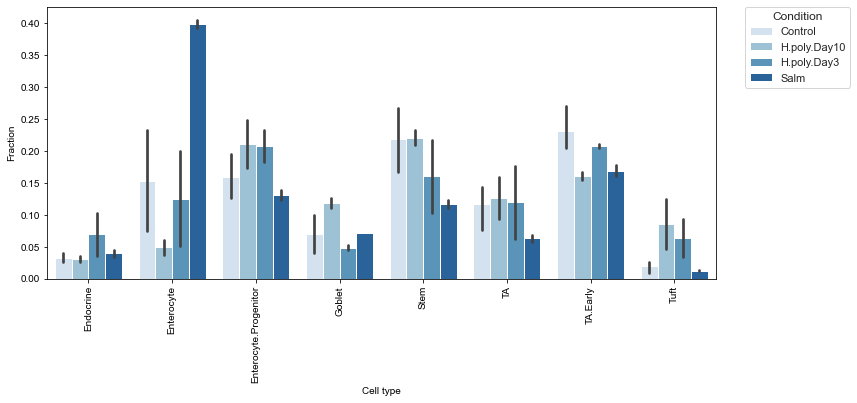

In [3]:
# Count data to ratios
counts = cell_counts.iloc[:, 1:-1]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["Condition"] = cell_counts["Condition"]

# Plot
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(ratios, id_vars=['Condition'], value_vars=ratios.columns[:-1])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue="Condition", data=df, palette="Blues")
d.set_ylabel('Fraction')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.legend(bbox_to_anchor=(1.2, 1), borderaxespad=0., title="Condition")

plot_path = "../data/benchmark_results/"
# plt.savefig(plot_path + "haber_bars_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_bars_blue.png", format="png", bbox_inches="tight")

plt.show()

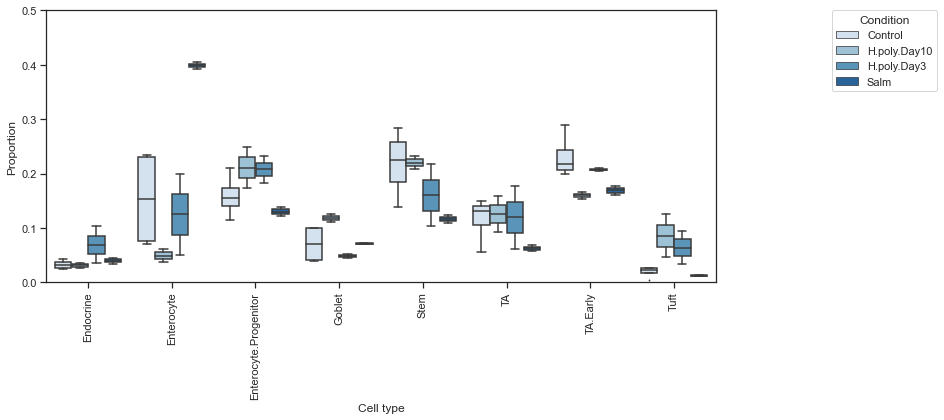

In [4]:
# Boxplots look a little better
fig, ax = plt.subplots(figsize=(12,5))
d = sns.boxplot(x='variable', y = 'value', hue=df["Condition"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Proportion')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
d.set_ylim([0,0.5])
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

# plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Apply scCODA to Salmonella (reference: Goblet cells)

--> Only Enterocytes are significant 

--> Haber et al: Enterocytes, Stem, TA, and TA (early) cells change

In [5]:
# model Salmonella
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_salmonella = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="automatic")
results_salmonella = model_salmonella.sample_hmc()

Automatic reference selection! Reference cell type set to Endocrine
MCMC sampling finished. (80.725 sec)
Acceptance rate: 56.4%


In [6]:
results_salmonella.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.193        37.199374
Enterocyte                       2.326       115.502472
Enterocyte.Progenitor            2.530       141.640468
Goblet                           1.676        60.297578
Stem                             2.708       169.235618
TA                               2.119        93.905780
TA.Early                         2.875       199.994914
Tuft                             0.423        17.223796


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        25.829800   
                  Enterocyte                    1.430821       335.408862   
       

Apply scCODA to H. Polygyrus 3 days (reference: TA cells)

--> No significant changes in cell composition

--> Haber et al: Tuft cells change

In [7]:
# model H. polygyrus day 3
data_hp3 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day3"])]

model_hp3 = mod.CompositionalAnalysis(data_hp3, formula="Condition", reference_cell_type="automatic")
results_hp3 = model_hp3.sample_hmc()

Automatic reference selection! Reference cell type set to TA.Early
MCMC sampling finished. (62.098 sec)
Acceptance rate: 68.2%


In [8]:
results_hp3.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 6
Formula: Condition
Spike-and-slab threshold: 0.579

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 62.098 sec. Acceptance rate: 68.2%

Intercepts:
                       Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                        0.702  -0.070    1.330  0.373   
Enterocyte                       1.741   1.169    2.312  0.306   
Enterocyte.Progenitor            2.043   1.447    2.578  0.302   
Goblet                           1.077   0.471    1.727  0.334   
Stem                             2.187   1.679    2.828  0.301   
TA                               1.653   1.066    2.269  0.320   
TA.Early                         2.323   1.783    2.855  0.288   
Tuft                             0.301  -0.412    0.985  0.379   

                       Expected Sample  
Cell Type                             

Apply scCODA to H. Polygyrus 10 days (reference: TA cells)

--> Enterocytes and Tuft cells are significant 

--> Haber et al: Enterocytes, Goblet, Tuft, and TA (early) cells change

In [9]:
# model H. polygyrus day 10
data_hp10 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day10"])]

model_hp10 = mod.CompositionalAnalysis(data_hp10, formula="Condition", reference_cell_type="automatic")
results_hp10 = model_hp10.sample_hmc()

Automatic reference selection! Reference cell type set to Endocrine
MCMC sampling finished. (59.703 sec)
Acceptance rate: 57.1%


In [10]:
results_hp10.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.742        38.791457
Enterocyte                       1.851       117.589536
Enterocyte.Progenitor            2.216       169.389374
Goblet                           1.430        77.184608
Stem                             2.453       214.691058
TA                               1.879       120.928572
TA.Early                         2.497       224.348367
Tuft                             0.448        28.910361


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte                   -0.747900   
                          Enterocyte.Progen

## Comparative analysis with *ancom*

We want to compare our findings to the results produced by applying *ancom*
[(Mandal et al., 2017)](https://pubmed.ncbi.nlm.nih.gov/26028277/) to the data.

In [11]:
salm_ancom = data_salm.copy()
salm_ancom.obs = salm_ancom.obs.rename(columns={"Condition": "x_0"})
model_salm_ancom = om.AncomModel(salm_ancom)
model_salm_ancom.fit_model()
print(model_salm_ancom.ancom_out)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False
3  0                   False
4  0                   False
5  0                   False
6  0                   False
7  0                   False, Percentile   0.0     25.0    50.0    75.0    100.0  0.0     25.0   50.0   \
Group      Control Control Control Control Control   Salm    Salm   Salm   
0              5.0   20.75    31.0   38.25    45.0   32.0   33.25   34.5   
1             46.0   55.75    78.5  128.75   221.0  332.0  342.25  352.5   
2             23.0  107.75   162.0  190.50   198.0  113.0  113.75  114.5   
3             20.0   32.00    36.0   58.00   124.0   59.0   61.00   63.0   
4             50.0  110.75   185.0  241.75   250.0   90.0   96.75  103.5   
5             11.0   96.50   127.5  136.25   155.0   47.0   51.50   56.0   
6             40.0  153.25   193.5  238.25   365.0  132.0  141.00  150.0   
7              4.0    4.75    11.5   21.75    33.0   

In [12]:

hp3_ancom = data_hp3.copy()
hp3_ancom.obs = hp3_ancom.obs.rename(columns={"Condition": "x_0"})
model_hp3_ancom = om.AncomModel(hp3_ancom)
model_hp3_ancom.fit_model()
print(model_hp3_ancom.ancom_out)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False
3  0                   False
4  0                   False
5  0                   False
6  0                   False
7  0                   False, Percentile   0.0     25.0    50.0    75.0    100.0       0.0         25.0   \
Group      Control Control Control Control Control H.poly.Day3 H.poly.Day3   
0              5.0   20.75    31.0   38.25    45.0        52.0       55.25   
1             46.0   55.75    78.5  128.75   221.0        75.0       87.75   
2             23.0  107.75   162.0  190.50   198.0       115.0      173.00   
3             20.0   32.00    36.0   58.00   124.0        33.0       41.25   
4             50.0  110.75   185.0  241.75   250.0        65.0      129.50   
5             11.0   96.50   127.5  136.25   155.0        39.0       95.00   
6             40.0  153.25   193.5  238.25   365.0       129.0      175.00   
7              4.0    4.75    11.5 

In [13]:

hp10_ancom = data_hp10.copy()
hp10_ancom.obs = hp10_ancom.obs.rename(columns={"Condition": "x_0"})
model_hp10_ancom = om.AncomModel(hp10_ancom)
model_hp10_ancom.fit_model()
print(model_hp10_ancom.ancom_out)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False
3  0                   False
4  0                   False
5  0                   False
6  0                   False
7  0                   False, Percentile   0.0     25.0    50.0    75.0    100.0        0.0          25.0   \
Group      Control Control Control Control Control H.poly.Day10 H.poly.Day10   
0              5.0   20.75    31.0   38.25    45.0         40.0        40.50   
1             46.0   55.75    78.5  128.75   221.0         57.0        60.50   
2             23.0  107.75   162.0  190.50   198.0        203.0       248.00   
3             20.0   32.00    36.0   58.00   124.0        147.0       152.75   
4             50.0  110.75   185.0  241.75   250.0        271.0       283.50   
5             11.0   96.50   127.5  136.25   155.0        109.0       142.75   
6             40.0  153.25   193.5  238.25   365.0        180.0       199.00   
7              4.

In [14]:
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_ancom = om.AncomModel(data_salm, covariate_column="Condition")
model_ancom.fit_model()
print(model_ancom.ancom_out)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False
3  0                   False
4  0                   False
5  0                   False
6  0                   False
7  0                   False, Percentile   0.0     25.0    50.0    75.0    100.0  0.0     25.0   50.0   \
Group      Control Control Control Control Control   Salm    Salm   Salm   
0              5.0   20.75    31.0   38.25    45.0   32.0   33.25   34.5   
1             46.0   55.75    78.5  128.75   221.0  332.0  342.25  352.5   
2             23.0  107.75   162.0  190.50   198.0  113.0  113.75  114.5   
3             20.0   32.00    36.0   58.00   124.0   59.0   61.00   63.0   
4             50.0  110.75   185.0  241.75   250.0   90.0   96.75  103.5   
5             11.0   96.50   127.5  136.25   155.0   47.0   51.50   56.0   
6             40.0  153.25   193.5  238.25   365.0  132.0  141.00  150.0   
7              4.0    4.75    11.5   21.75    33.0   